# Step 3. Flower Classifier - Artificial Neural Network - Baseline Model

This is a simple Artificial Neural Network with 4 hidden layers.

Optimizer: `tf.keras.optimizers.Adam`

According to [Tensorflow API docs](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam), Adam optimization is a stochastic gradient descent method based on adaptive estimation of first-order and second-order moments. This method is "computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters". Thus, this is a good fit for our task of image classification, since we will generate a large amount of trainable parameters that has large computing power requirement that we aim to minimize while still ensuring our model's performance.

Since our data is balanced, the metric we are using to evaluate its performance is **Accuracy** ($Accuracy = \frac{correct \; classifications}{all \; classifications}$), more specifically its [Tensorflow's CategoricalAccuracy Implementation](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/CategoricalAccuracy).

Refer to the code below to see how it is set up, trained, and evaluated.

Subsequent models developed will have their performance measured against this model.

In [1]:
# Imports and environmental setups

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam


# Custom utils functions
from utils import dataset
from utils.visualization import plot_learning_curve
from utils.visualization import visualize_16predictions
from utils.glob import TARGET_IMG_SIZE


# Reproducible results
np.random.seed(99)
tf.random.set_seed(42)

# Misc.
plt.style.use('ggplot')
model_name = 'clf-ann'
dir_raw_dataset = '../data/raw/'
dir_train_dataset = '../data/train/'
dir_test_dataset = '../data/test/'
dir_log = '../log/' + model_name
dir_models = '../models/'
path_model = dir_models + model_name

## 3.1. Load Dataset

In [2]:
df = dataset.load(dir_train_dataset)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13073 entries, 0 to 13072
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ImgPath       13073 non-null  object 
 1   FileType      13073 non-null  object 
 2   Width         13073 non-null  int64  
 3   Height        13073 non-null  int64  
 4   Ratio         13073 non-null  float64
 5   Mode          13073 non-null  object 
 6   Bands         13073 non-null  object 
 7   Transparency  13073 non-null  bool   
 8   Animated      13073 non-null  bool   
 9   Class         13073 non-null  object 
dtypes: bool(2), float64(1), int64(2), object(5)
memory usage: 842.7+ KB


In [4]:
df.sample(n=42, random_state=42)

,ImgPath,FileType,Width,Height,Ratio,Mode,Bands,Transparency,Animated,Class
10022,Rosy/000274.jpg,jpg,256,256,1.0,RGB,R G B,False,False,Rosy
11756,Tana/000414.jpg,jpg,256,256,1.0,RGB,R G B,False,False,Tana
12394,Tana/001211.jpg,jpg,256,256,1.0,RGB,R G B,False,False,Tana
11387,Rosy/rosy_60.jpg,jpg,256,256,1.0,RGB,R G B,False,False,Rosy
7551,Lisianthus/lisianthus_247.jpg,jpg,256,256,1.0,RGB,R G B,False,False,Lisianthus
6202,Hydrangeas/hydrangeas_187.jpg,jpg,256,256,1.0,RGB,R G B,False,False,Hydrangeas
5714,Hydrangeas/001008.jpg,jpg,256,256,1.0,RGB,R G B,False,False,Hydrangeas
7990,Lisianthus/lisianthus_761.jpg,jpg,256,256,1.0,RGB,R G B,False,False,Lisianthus
12896,Tana/tana_458.jpg,jpg,256,256,1.0,RGB,R G B,False,False,Tana
3288,Chrysanthemum/000005.jpg,jpg,256,256,1.0,RGB,R G B,False,False,Chrysanthemum


In [5]:
train, val = train_test_split(df, shuffle=True, test_size=0.25, random_state=42)  # 80/20/20 - train/val/test

print(f'Train data: {train.shape[0]} samples, Validation Data: {val.shape[0]} samples.')

Train data: 9804 samples, Validation Data: 3269 samples.


## 3.2. Model Setup and Training

### 3.2.1. Hyper-parameters

In [6]:
# Model Parameters
BATCH_SIZE = 512
INPUT_DIM = (TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3)  # RGB - 3 channels images
HIDDEN_LAYER_DIM = 128
OUTPUT_CLASSES = 8  # One-hot encoded: 8 different classes

# Training Parameters
EPOCHS = 32
LEARNING_RATE = 1e-6

### 3.2.2. Model Architecture

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
], name=model_name)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy'],
)

In [8]:
model.summary()

Model: "clf-ann"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 128)               25165952  
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 25,216,520
Trainable params: 25,216,520
Non-t

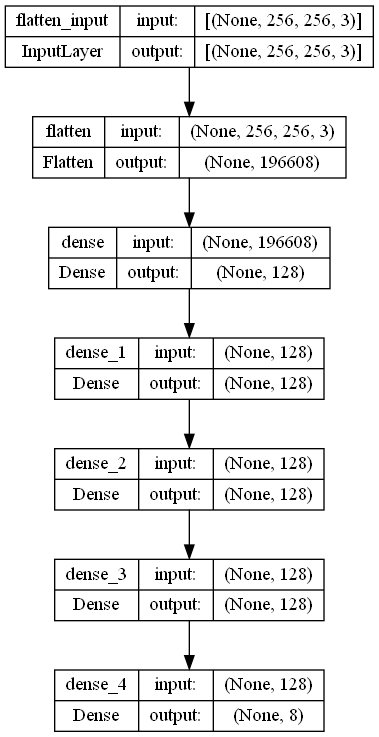

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file=f'images/{model_name}-Diagram.png')

### 3.2.3. Training

In [10]:
train['Class'] = train['Class'].astype('str')
train_datagen = ImageDataGenerator(data_format='channels_last')
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=dir_train_dataset,
    x_col='ImgPath',
    y_col='Class',
    target_size=(TARGET_IMG_SIZE, TARGET_IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

val['Class'] = val['Class'].astype('str')
val_datagen = ImageDataGenerator(data_format='channels_last')
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val,
    directory=dir_train_dataset,
    x_col='ImgPath',
    y_col='Class',
    target_size=(TARGET_IMG_SIZE, TARGET_IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

Found 9804 validated image filenames belonging to 8 classes.
Found 3269 validated image filenames belonging to 8 classes.


In [11]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=dir_log)
history = model.fit(
    train_generator, validation_data=val_generator,
    epochs=EPOCHS,
    verbose=2, callbacks=[tensorboard_callback],
)

Epoch 1/32
20/20 - 25s - loss: 2.1818 - categorical_accuracy: 0.1311 - val_loss: 2.1196 - val_categorical_accuracy: 0.1444 - 25s/epoch - 1s/step
Epoch 2/32
20/20 - 24s - loss: 2.0965 - categorical_accuracy: 0.1479 - val_loss: 2.0905 - val_categorical_accuracy: 0.1606 - 24s/epoch - 1s/step
Epoch 3/32
20/20 - 23s - loss: 2.0562 - categorical_accuracy: 0.1908 - val_loss: 2.0522 - val_categorical_accuracy: 0.1890 - 23s/epoch - 1s/step
Epoch 4/32
20/20 - 23s - loss: 2.0364 - categorical_accuracy: 0.1883 - val_loss: 2.0316 - val_categorical_accuracy: 0.1979 - 23s/epoch - 1s/step
Epoch 5/32
20/20 - 22s - loss: 2.0009 - categorical_accuracy: 0.2400 - val_loss: 1.9951 - val_categorical_accuracy: 0.2230 - 22s/epoch - 1s/step
Epoch 6/32
20/20 - 24s - loss: 1.9867 - categorical_accuracy: 0.2496 - val_loss: 1.9933 - val_categorical_accuracy: 0.2215 - 24s/epoch - 1s/step
Epoch 7/32
20/20 - 26s - loss: 1.9654 - categorical_accuracy: 0.2571 - val_loss: 1.9689 - val_categorical_accuracy: 0.2603 - 26s/e

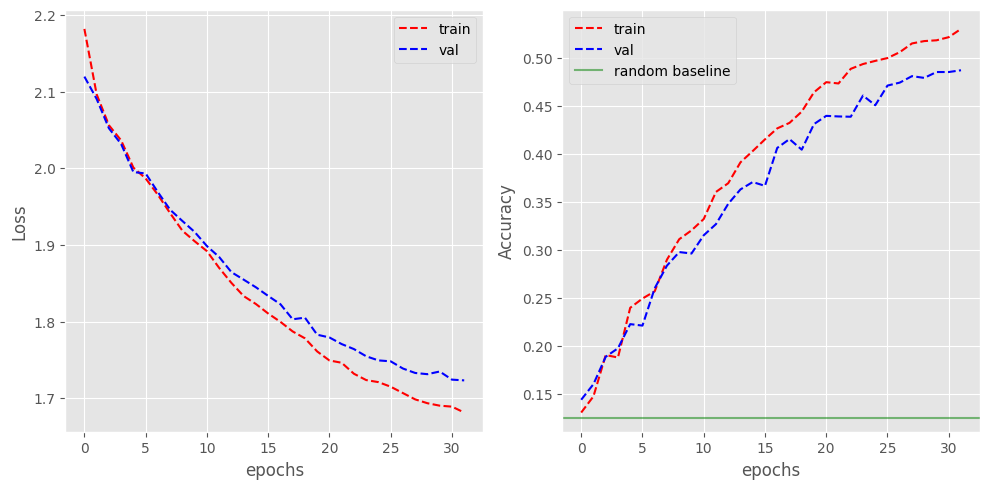

In [12]:
plot_learning_curve(
    history.history['loss'],
    history.history['val_loss'],
    history.history['categorical_accuracy'],
    history.history['val_categorical_accuracy'],
    to_file=f'images/{model_name}-LearningCurve.png'
)

## 3.3. Model Performance

Evaluated against test dataset in `./data/test/`

In [13]:
test = dataset.load(dir_test_dataset)
test['Class'] = test['Class'].astype('str')
test_datagen = ImageDataGenerator(data_format='channels_last')
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=dir_test_dataset,
    x_col='ImgPath',
    y_col='Class',
    target_size=(TARGET_IMG_SIZE, TARGET_IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    seed=42
)

Found 3271 validated image filenames belonging to 8 classes.


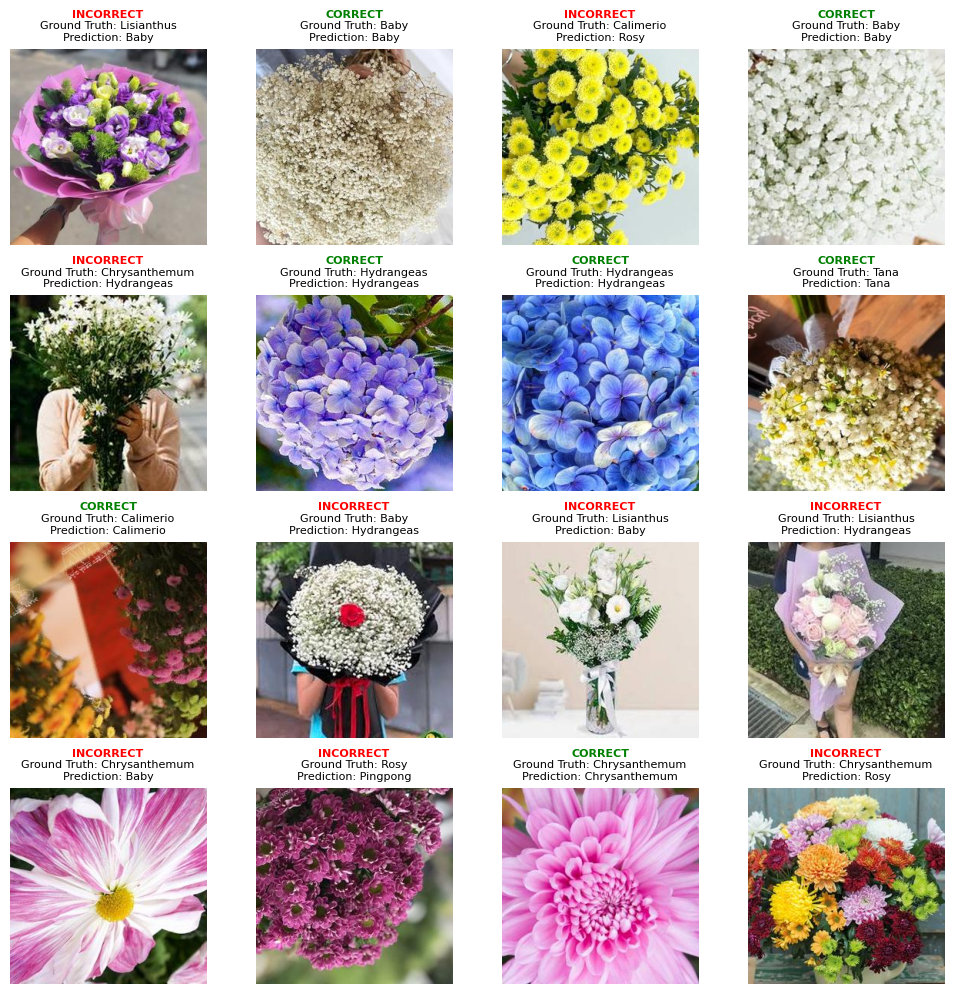

In [14]:
visualize_16predictions(model, test_generator, to_file=f'images/{model_name}-16SamplePredictions.png')

In [15]:
model.evaluate(test_generator)

3271/3271 [==============================] - 41s 12ms/step - loss: 1.7219 - categorical_accuracy: 0.4867


[1.721880316734314, 0.4867013096809387]

**☞ Observation**

Our baseline classification model seems to have reached peak capacity at around $0.5$ accuracy, higher than random chance of $\frac{1}{8}=0.125$.

From inspecting the test predictions, we can see that the noise (irrelevant details, different flower types in the same image, background, people, etc.) in our data has a negative effect on our accuracy.

This is indicative that our model can capture some, but not all important features in the training dataset, and needs further tweaking in order to achieve higher accuracy and more resistance to noise.

## 3.4. Model Exporting

In [16]:
model.save(path_model, overwrite = True)

INFO:tensorflow:Assets written to: ../models/clf-ann\assets
